## 1) Carregando o Dataset

In [12]:
from pathlib import Path
import pandas as pd

# A função pd.read_csv() lê o arquivo e o carrega em um DataFrame do pandas.
DATA_PATH = Path.cwd().joinpath(Path("Exercicio01/dataset/data_0460_5832.csv"))
df = pd.read_csv(DATA_PATH)

# O comando .head() mostra as 5 primeiras linhas do DataFrame.
print("Primeiras 5 linhas do dataset:")
print(df.head())

# O comando .info() mostra um resumo técnico, incluindo os tipos de cada coluna.
print('\nInformações do DataFrame:')
df.info()

Primeiras 5 linhas do dataset:
      Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB


## 2) Tratamento dos dados

Antes de treinar nosso modelo, precisamos preparar os dados. Isso envolve:

1.  **Lidar com variáveis categóricas**: A coluna `Sex` é categórica ('Male'/'Female'). Os modelos de regressão linear requerem entradas numéricas. Usaremos uma técnica chamada *one-hot encoding* para converter essa coluna em colunas numéricas (0s e 1s).
2.  **Definir Features (X) e Target (y)**: Separaremos nosso conjunto de dados em:
    * `X`: a matriz de features (as variáveis que usaremos para fazer a previsão).
    * `y`: o vetor alvo (a variável que queremos prever, neste caso, `Weight`).

In [13]:
import numpy as np

# Copiar o df original para não sobrescrever
df_encoded = df.copy()

# Identificar colunas categóricas que só têm dois valores
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    valores = df_encoded[col].dropna().unique()
    if len(valores) == 2:
        # mapear automaticamente para 0/1
        mapping = {valores[0]: 0, valores[1]: 1}
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Coluna {col} mapeada para {mapping}")
    else:
        df_encoded.drop(columns=[col], inplace=True)
# remove colunas constantes
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if df_encoded[c].nunique(dropna=True) > 1]


Coluna Sex mapeada para {'Female': 0, 'Male': 1}


In [20]:
# --- imports necessários ---
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# --------- treino SGD com histórico ---------
def fit_logreg_sgd_with_history(
    X_np, y_np, *, lr=1e-2, epochs=600, batch_size=32, seed=0
):
    """
    Regressão logística binária com SGD (mini-batch) em PyTorch.
    Guarda históricos de BCE e acurácia por época e devolve (modelo, scaler, history).
    """
    g = torch.Generator().manual_seed(seed)
    torch.manual_seed(seed)
    rng = np.random.RandomState(seed)

    # padroniza (como fizemos no BGD)
    scaler = StandardScaler().fit(X_np)
    Xz = scaler.transform(X_np).astype(np.float32)
    y  = y_np.astype(np.float32).reshape(-1, 1)

    X = torch.tensor(Xz, dtype=torch.float32)
    y = torch.tensor(y,  dtype=torch.float32)

    model = torch.nn.Linear(X.shape[1], 1)
    crit  = torch.nn.BCEWithLogitsLoss()
    opt   = torch.optim.SGD(model.parameters(), lr=lr)

    bce_hist, acc_hist = [], []

    for ep in range(1, epochs+1):
        # baralha e varre em mini-lotes
        idx = rng.permutation(X.shape[0])
        for i in range(0, X.shape[0], batch_size):
            bs = torch.tensor(idx[i:i+batch_size], dtype=torch.long)
            xb, yb = X.index_select(0, bs), y.index_select(0, bs)

            opt.zero_grad()
            logits = model(xb)
            loss   = crit(logits, yb)
            loss.backward()
            opt.step()

        # métricas (em todo o treino) p/ histórico
        with torch.no_grad():
            logits_all = model(X)
            prob_all   = torch.sigmoid(logits_all).cpu().numpy().ravel()
            pred_all   = (prob_all >= 0.5).astype(int)
            acc = accuracy_score(y_np.ravel().astype(int), pred_all)
            bce = float(crit(logits_all, y).detach().cpu())
        bce_hist.append(bce)
        acc_hist.append(acc)

    history = {"bce": bce_hist, "acc": acc_hist}
    return {"model": model, "scaler": scaler, "history": history}


# --------- plots de treino (loss/acc) + avaliação no teste (ROC + matriz) ---------
def plot_logreg_sgd(out, X_te, y_te):
    model, scaler, hist = out["model"], out["scaler"], out["history"]

    # curvas de treino
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(hist["bce"]); ax[0].set_title("SGD: BCE (treino)"); ax[0].set_xlabel("Época"); ax[0].set_ylabel("BCE")
    ax[1].plot(hist["acc"]); ax[1].set_title("SGD: Acurácia (treino)"); ax[1].set_xlabel("Época"); ax[1].set_ylabel("Acc")
    plt.tight_layout(); plt.show()

    # avaliação no teste
    X_te_scaled = scaler.transform(X_te).astype(np.float32)
    Xt = torch.tensor(X_te_scaled, dtype=torch.float32)
    with torch.no_grad():
        prob = torch.sigmoid(model(Xt)).cpu().numpy().ravel()
    pred = (prob >= 0.5).astype(int)

    # ROC (cálculo robusto, sem depender de versão do sklearn)
    fpr, tpr, _ = roc_curve(y_te.ravel().astype(int), prob)
    auc_val = auc(fpr, tpr)

    # matriz de confusão + ROC
    cm = confusion_matrix(y_te.ravel().astype(int), pred)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    im = ax[0].imshow(cm, cmap="Blues")
    ax[0].set_title("Matriz de confusão (teste)")
    ax[0].set_xlabel("Previsto"); ax[0].set_ylabel("Verdadeiro")
    for (i, j), v in np.ndenumerate(cm):
        ax[0].text(j, i, str(v), ha='center', va='center')
    plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

    ax[1].plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    ax[1].plot([0,1],[0,1],'k--', lw=1)
    ax[1].set_title("Curva ROC (teste)")
    ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR")
    ax[1].legend(loc="lower right")
    plt.tight_layout(); plt.show()

    # imprime métricas rápidas
    print(f"Teste — acc={accuracy_score(y_te, pred):.3f}  |  AUC={auc_val:.3f}")

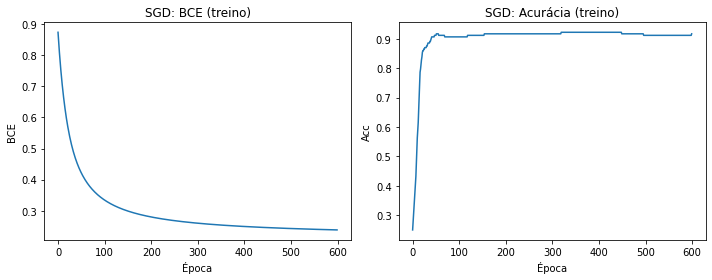

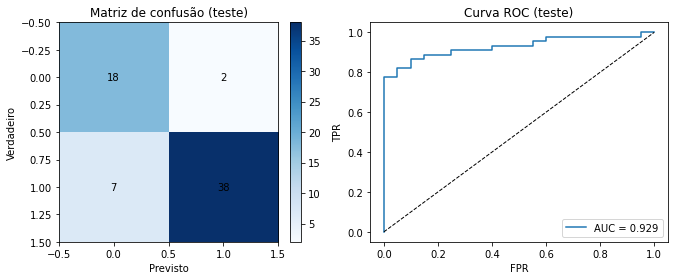

Teste — acc=0.862  |  AUC=0.929


In [21]:
sgd_out = fit_logreg_sgd_with_history(X_tr, y_tr, lr=1e-2, epochs=600, batch_size=32, seed=0)
plot_logreg_sgd(sgd_out, X_te, y_te)